In [1]:
import wfdb
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

# pat_id = 101

# Read a record from the database
# record = wfdb.rdrecord(f'./data/mitdb/{pat_id}')

In [2]:
# Read annotations
# annotation = wfdb.rdann(f'./data/mitdb/{pat_id}', 'atr')
# symbol = annotation.symbol
# location = annotation.sample

In [3]:
# Find RR-intervals and min and max of each set
# rr_intervals = []
# for i in range(2, len(location)):
#     rr_intervals.append(location[i]-location[i-1])

# print(rr_intervals)
# print(min(rr_intervals))
# print(max(rr_intervals))

In [4]:
# Read record numbers
with open('./data/mitdb/RECORDS') as f:
    records = f.readlines()

for i in range(0,len(records)):
    records[i] = int(records[i])
    

In [5]:
# Find RR-intervals for all records
# Check abnormally long/short intervals
rr_intervals = []
check = [] 
check_low = []

for id in records:
    pat_id = id
    annotation = wfdb.rdann(f'./data/mitdb/{pat_id}', 'atr')
    location = annotation.sample
    for i in range(2, len(location)):
        if location[i]-location[i-1] > 1270:
            check.append(id)
        if location[i]-location[i-1] < 25:
            check_low.append(id)
        rr_intervals.append(location[i]-location[i-1])

(array([2.9400e+02, 1.8590e+03, 4.6440e+03, 1.5964e+04, 3.2821e+04,
        3.0903e+04, 1.4871e+04, 7.0300e+03, 2.9980e+03, 6.8800e+02,
        1.3700e+02, 6.6000e+01, 1.0900e+02, 5.6000e+01, 1.2000e+01,
        8.0000e+00, 1.0000e+01, 1.8000e+01, 2.2000e+01, 6.0000e+00,
        6.0000e+00, 9.0000e+00, 3.0000e+00, 2.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 3.0000e+00, 4.0000e+00, 2.0000e+00,
        2.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00, 1.0000e+00]),
 array([   6. ,   58.7,  111.4,  164.1,  216.8,  269.5,  322.2,  374.9,
         427.6,  480.3,  533. ,  585.7,  638.4,  691.1,  743.8,  796.5,
         849.2,  901.9,  954.6, 1007.3, 1060. , 1112.7, 1165.4, 1218.1,
        1270.8, 1323.5, 1376.2, 1428.9, 1481.6, 1534.3, 1587. , 1639.7,
        1692.4, 1745.1, 1797.8, 1850.5, 1903.2, 1955.9, 2008.6, 2061.3,
        2114. ]),
 <BarContainer object of 40 artists>)

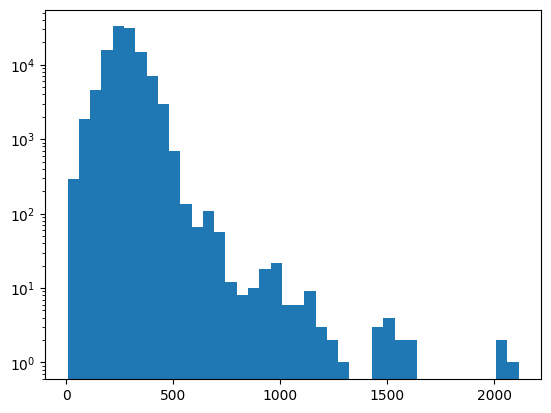

In [6]:
# Plot distribution of RR-intervals
plt.hist(rr_intervals, bins=40, log=True)

In [7]:
annotation = wfdb.rdann(f'./data/mitdb/{pat_id}', 'atr')
record = wfdb.rdrecord(f'./data/mitdb/{pat_id}')
loc = annotation.sample
beat_type = annotation.symbol
signal = record.p_signal[:,0]
beat_type


['+',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N'

In [8]:
# Segment by using relative minimum RR-interval
segments = []
beat_types = []

classes = {0:'N',1:'S',2:'V',3:'F',4:'Q'}
reduced = {'N':['N','L','R','e','j'],
                 'S':['S','A','a','J'],'V':['V','E'],'F':['F'],'Q':['/','Q','f']}

reverse_reduced = {}

for key, values in reduced.items():
    for value in values:
        reverse_reduced[value] = key

ValueError: not enough values to unpack (expected 2, got 1)

112503


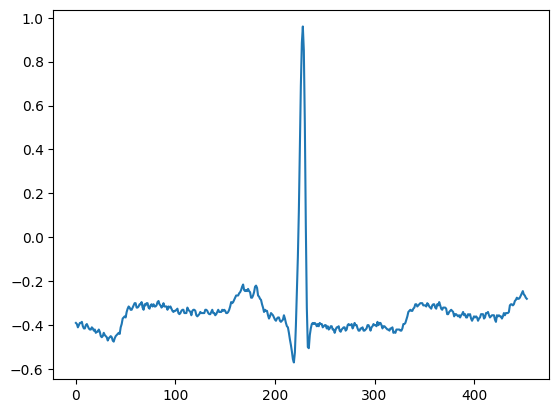

In [ ]:
for id in records:
    pat_id = id
    annotation = wfdb.rdann(f'./data/mitdb/{pat_id}', 'atr')
    record = wfdb.rdrecord(f'./data/mitdb/{pat_id}')
    loc = annotation.sample
    beat_type = annotation.symbol
    signal = record.p_signal[:,0]

    for i in range(2, len(loc)-1):
        dist = round(min(loc[i]-loc[i-1], loc[i+1]-loc[i]) * 0.8)
        segments.append(signal[loc[i]-dist:loc[i]+dist])

print(len(segments))
plt.plot(segments[1])


In [ ]:
max_len = len(segments[0])
sum = 0
for segment in segments:
    sum += len(segment)
    max_len = max(len(segment), max_len)

max_len
sum

1546